# Using Pytorch to recognise fashion artefacts

Process:
- load and visualise the data
- preprocess data
- define model
- train model
- save the best model
- test model

Based on:
https://colab.research.google.com/drive/1nkAZaX5QQhnO3XN3FE27jW3JKk0tcPd_?usp=sharing#scrollTo=JZcQH0Bto_Gy
https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4

## Import required libraries

In [9]:
# Run the following commands using terminal (exclude # !) or directly from cell (remove #)
# !pip3 install pytorch
# !pip3 install torchvision

- torch.optim implement various optimization algorithms like SGD and Adam.
- torch.nn.functional for non-linear activation functions like relu, softmin, softmax, logsigmoid, etc.
- The torchvision packages consist of popular datasets, model architectures, and common image transformations for computer vision. We are using datasets and transform from torchvision to download a fashion-MNIST dataset and transforms an image using compose transformations.
- Subset RandomSampler used to split the dataset into train and validation subsets for validation of our model.

In [2]:
# Import Libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Prepare data
- transforms.Compose creates a series of transformation to prepare the dataset.
- transforms.ToTenser convert PIL image(L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
- transform.Normalize Normalize a tensor image with mean and standard deviation. Tensor image size should be (C x H x W) to be normalized which we already did usetransforms.ToTenser.
- transform.Normalize Normalize a tensor image with mean and standard deviation. Tensor image size should be (C x H x W) to be normalized which we already did usetransforms.ToTenser.
- datasets.FashionMNIST to download the Fashion MNIST datasets and transform the data. train=True if we want to get trained dataset otherwise set the parameter False for the test dataset.
- torch.utils.data.Dataloader takes our data train or test data with parameter batch_size and shuffle. batch_size define the how many samples per batch to load, and shuffle parameter set the True to have the data reshuffled at every epoch.


In [12]:
# Define a transform to convert images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values
                          
# Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

# Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [13]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/studio-lab-user/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [14]:
trainloader

## Display pictures

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)

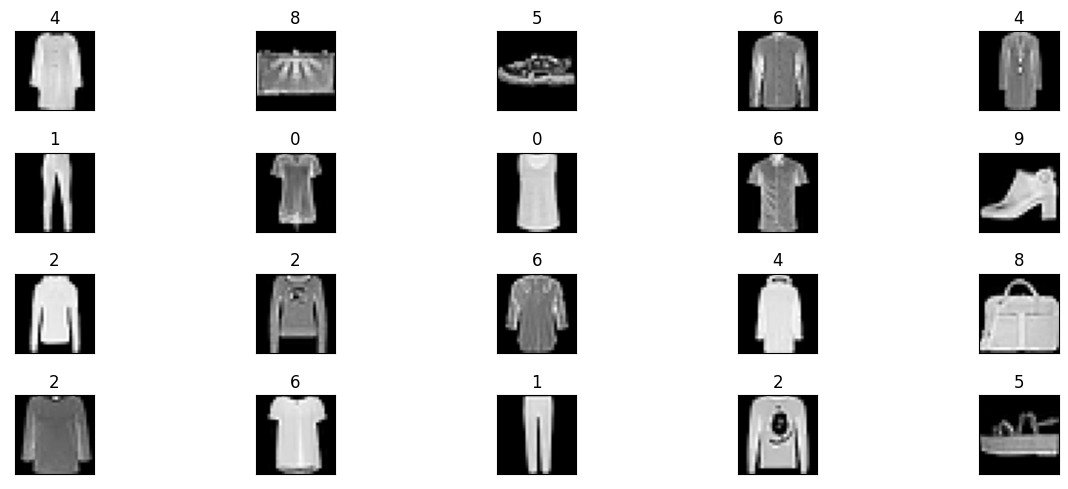

In [5]:
fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  # np.sqeeze : Remove single-dimensional entries from the shape of an array
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

# Build the network

## Define layers
- Input layer - images are 28x28 2D tensors, flattened into 1D vector (28x28 = 784)
- Hidden layer - arbitrary number, 3 in this example
- Output layer - 1 layer, with 10 neurons to match the classification of clothes

In [23]:
# nn.Module - module to build neural networks provided by Pytorch
class Classifier(nn.Module):
  def __init__(self):
    # create a class to define the architecture
    super().__init__()
    # define layers (input, output)
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)
    # defining the 20% dropout
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    # not using dropout on output layer
    # for output layer pass data through the Log Softmax function to obtain the log-probabilities in neural-network
    x = F.log_softmax(self.fc3(x), dim=1)
    return x   

In [24]:
model = Classifier()
#defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

valid_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 40
steps = 0
model.train() #prep model for training
train_losses, valid_losses = [],[]
for e in range(epochs):
  running_loss =0 
  valid_loss = 0
   # train the model #
  for images, labels in trainloader:

     optimizer.zero_grad()
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     loss.backward()
     optimizer.step()
     running_loss += loss.item()*images.size(0)
  
  for images, labels in validloader:
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     valid_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(trainloader.sampler)
  valid_loss =  valid_loss/len(validloader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))
  if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 128x64)

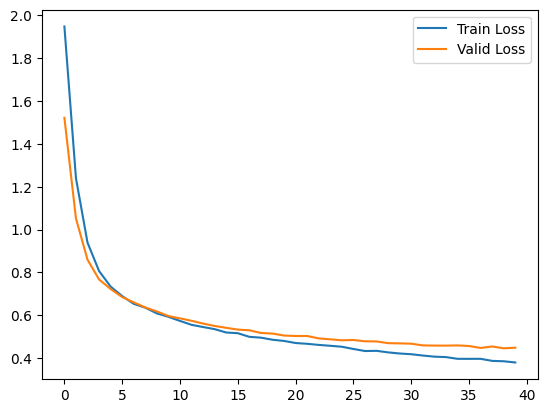

In [43]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [44]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [45]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in testloader:
  #forword pass 
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.433579

Test Accuracy of     0: 81% (811/1000)
Test Accuracy of     1: 94% (949/1000)
Test Accuracy of     2: 72% (728/1000)
Test Accuracy of     3: 86% (861/1000)
Test Accuracy of     4: 76% (765/1000)
Test Accuracy of     5: 92% (922/1000)
Test Accuracy of     6: 59% (592/1000)
Test Accuracy of     7: 89% (890/1000)
Test Accuracy of     8: 94% (948/1000)
Test Accuracy of     9: 93% (937/1000)

Test Accuracy (Overall): 84% (8403/10000)


0: T-shirt/Top
1: Trouser
2: PullOver
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle Bot

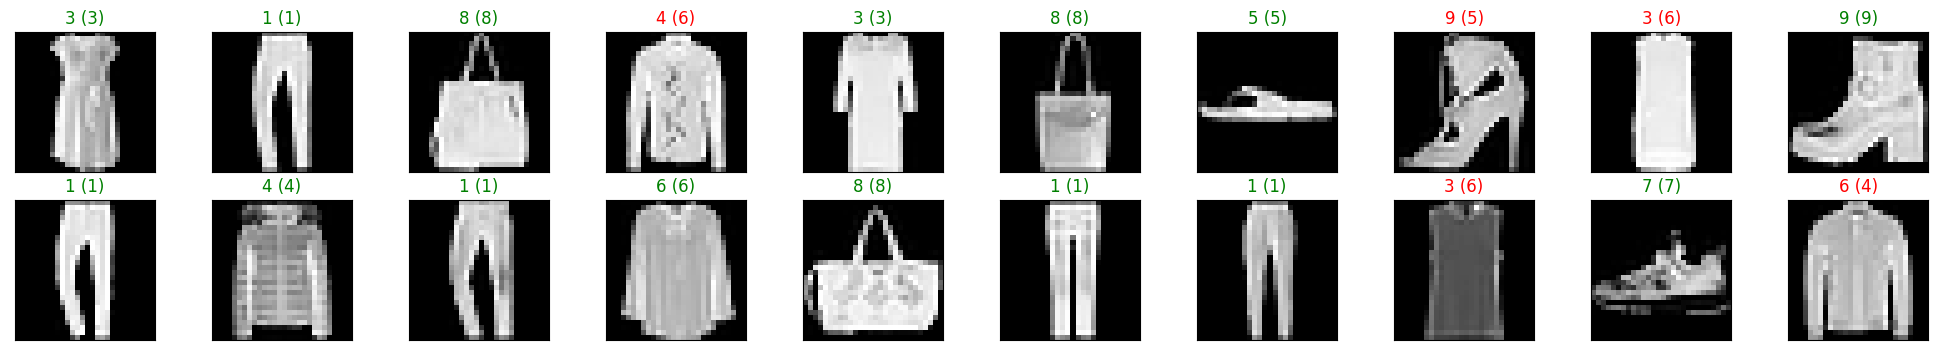

In [48]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))